In [ ]:
import kagglehub

datapath = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")
print("Path to dataset: ", datapath)

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
datapath = "C:\\Users\\subin\\.cache\\kagglehub\\datasets\\waalbannyantudre\\hate-speech-detection-curated-dataset\\versions\\1"

In [4]:
df = pd.read_csv(Path(datapath, "tweet_hate-speech.csv"))

In [5]:
df.head()

,Content,Label,Content_int
0,denial of normal the con be asked to comment o...,1,"[146715, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,..."
1,just by being able to tweet this insufferable ...,1,"[146715, 14, 15, 16, 17, 7, 18, 19, 20, 21, 22..."
2,that is retarded you too cute to be single tha...,1,"[146715, 28, 29, 30, 26, 31, 32, 7, 5, 33, 28,..."
3,thought of a real badass mongol style declarat...,1,"[146715, 35, 1, 24, 36, 37, 38, 39, 40, 1, 41,..."
4,afro american basho,1,"[146715, 46, 47, 48, 146714]"


In [6]:
df.shape

(440906, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440906 entries, 0 to 440905
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Content      440906 non-null  object
 1   Label        440906 non-null  object
 2   Content_int  440906 non-null  object
dtypes: object(3)
memory usage: 10.1+ MB


In [8]:
df.drop(columns='Content_int', axis=1, inplace=True)

In [9]:
df['Label'].value_counts()

Label
0        361594
1         79305
Label         7
Name: count, dtype: int64

In [10]:
df = df[df['Label']!='Label']

In [11]:
df['Label'] = df['Label'].astype(int)

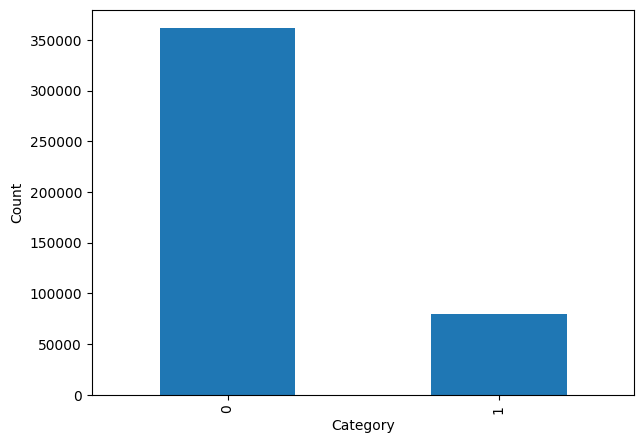

In [12]:
labels_count = df['Label'].value_counts()
plt.figure(figsize=(7,5))
labels_count.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [13]:
subset_hate_df = df[df['Label']==1].sample(n=60000, random_state=42)
subset_nornal_df = df[df['Label']==0].sample(n=60000, random_state=42)

In [14]:
subset_df = pd.concat([subset_hate_df, subset_nornal_df])

In [15]:
subset_df.shape

(120000, 2)

In [16]:
subset_df['Label'].value_counts()

Label
1    60000
0    60000
Name: count, dtype: int64

## Text Prepocessing

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

###### All word in the text corpus is already in lower case with no punctuations so skipping those steps.

In [19]:
# Removing Stopwords from texts
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words]
    
    return " ".join(text)

In [20]:
# Lemmatizing words
def lemmatization(text):
    lemmtizer = WordNetLemmatizer()
    text_words = text.split()
    text = [lemmtizer.lemmatize(word) for word in text_words]

    return " ".join(text)

In [21]:
# Check for spelling mistakes
def check_spell(text):
    text_blob = TextBlob(text)
    correct_text = str(text_blob.correct())
    
    return correct_text

In [22]:
# Preprocessing function
def preprocess(df):
    try:
        df['Content'] = df['Content'].apply(remove_stopwords)
        #df['Content'] = df['Content'].apply(check_spell)
        df['Content'] = df['Content'].apply(lemmatization)

        print("Finished preprocessing successfully")
        return df
    except Exception as e:
        print(f"Error during preprocessing: {e}")
        raise

In [23]:
norm_df = preprocess(subset_df)
norm_df.head()

Finished preprocessing successfully


,Content,Label
100185,retweet reject constantly call house threateni...,1
97778,purpose whatever attack everyone cannot adhere...,1
169017,fucking kidding deserve fucking rot,1
132101,retweet racist sexist tired self entitlement,1
24015,imagine two million spent security next royal ...,1


In [24]:
# Shuffle the rows
norm_df = norm_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
norm_df.head()

,Content,Label
0,notability magnus howie tag placed magnus howi...,0
1,big plan,0
2,najbolje je idea jean idea drug ako see bird m...,1
3,disruptive appear attention seeking remark arg...,1
4,reign man really ignorant person perfect examp...,1


In [26]:
norm_df.to_csv("final_dataset.csv", index=False)

## Preparing Base Model

In [ ]:
import numpy as np
import pandas as pd
norm_df = pd.read_csv("final_dataset.csv")

In [2]:
norm_df.isnull().sum()

Content    71
Label       0
dtype: int64

In [3]:
norm_df.dropna(how='any', inplace=True)

In [4]:
norm_df['Label'].value_counts()

Label
1    59976
0    59953
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Using BOW technique for vocabulary
cv = CountVectorizer(max_features=1000)
X = cv.fit_transform(norm_df['Content'])
y = norm_df['Label'].values.ravel()

In [68]:
X.shape, y.shape

((119929, 1000), (119929,))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
X_train.shape, y_train.shape

((95943, 1000), (95943,))

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

uri = os.getenv("MLFLOW_URI")
repo_owner = os.getenv("OWNER")
repo_name = os.getenv("REPO")

In [ ]:
import mlflow
import dagshub

if uri is None:
	raise ValueError("MLFLOW_URI environment variable is not set.")
mlflow.set_tracking_uri(uri)

if repo_owner or repo_name is None:
	raise ValueError("Missing dagshub logging environment credentials.")
dagshub.init(repo_owner=repo_owner, repo_name=repo_name, mlflow=True)

mlflow.set_experiment("Baseline Models")

In [ ]:
with mlflow.start_run(run_name="Logistic Regression-B1"):
    try:
        mlflow.log_param("vectorizer", "Bag-of-Words")
        mlflow.log_param("num_features", 1000)

        model1 = LogisticRegression(solver="lbfgs", max_iter=2500, n_jobs=-1)

        print("Training Logistic Regression model...")
        model1.fit(X_train, y_train)

        mlflow.log_param("baseline_model1", "Logistic Regression-B1")

        print("Model training completed. Making evaluating model...")
        y_pred = model1.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")

        print("Logging metrics to MLflow...")
        mlflow.log_metric("accuracy", float(accuracy))
        mlflow.log_metric("precision", float(precision))
        mlflow.log_metric("recall", float(recall))
        mlflow.log_metric("f1", float(f1))
        print("Done!")

    except Exception as e:
        print(f"Error in model training and or tracking: {e}")
        raise e

Training Logistic Regression model...
Model training completed. Making evaluating model...
Accuracy: 0.7690736262819978
Precision: 0.7741134144252184
Recall: 0.7569310662534551
F1: 0.7654258247575488
Logging metrics to MLflow...
Done!
🏃 View run Logistic Regression-B1 at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0/runs/0881ecb435ae4b61aab0beb701918ec1
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0


In [ ]:
with mlflow.start_run(run_name="Logistic Regression-B2"):
    try:
        mlflow.log_param("vectorizer", "Bag-of-Words")
        mlflow.log_param("num_features", 1000)

        model2 = LogisticRegression(solver="saga", penalty='l2', max_iter=2000, n_jobs=-1)

        print("Training Logistic Regression model...")
        model2.fit(X_train, y_train)

        mlflow.log_param("baseline_model2", "Logistic Regression-B2")

        print("Model training completed. Making evaluating model...")
        y_pred = model2.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")

        print("Logging metrics to MLflow...")
        mlflow.log_metric("accuracy", float(accuracy))
        mlflow.log_metric("precision", float(precision))
        mlflow.log_metric("recall", float(recall))
        mlflow.log_metric("f1", float(f1))
        print("Done!")

    except Exception as e:
        print(f"Error in model training and or tracking: {e}")
        raise e

Training Logistic Regression model...
Model training completed. Making evaluating model...
Accuracy: 0.7695739181189027
Precision: 0.7723874256584536
Recall: 0.7614540581288215
F1: 0.7668817748534312
Logging metrics to MLflow...
Done!
🏃 View run Logistic Regression-B2 at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0/runs/0fcb0a3f4de449b8b5fbe4fe6d155fb3
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0


#### Running more expreriments ...

In [ ]:
# Increasing vocabulary size to 1500
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(norm_df['Content'])
y = norm_df['Label'].values.ravel()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
with mlflow.start_run(run_name="Logistic Regression-B4"):
    try:
        mlflow.log_param("vectorizer", "Bag-of-Words")
        mlflow.log_param("num_features", 1500)

        model4 = LogisticRegression(solver="lbfgs", penalty='l2', max_iter=2000, C=0.1, n_jobs=-1)

        print("Training Logistic Regression model...")
        model4.fit(X_train, y_train)

        mlflow.log_param("baseline_model4", "Logistic Regression-B4")

        print("Model training completed. Making evaluating model...")
        y_pred = model4.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")

        print("Logging metrics to MLflow...")
        mlflow.log_metric("accuracy", float(accuracy))
        mlflow.log_metric("precision", float(precision))
        mlflow.log_metric("recall", float(recall))
        mlflow.log_metric("f1", float(f1))
        print("Done!")

    except Exception as e:
        print(f"Error in model training and or tracking: {e}")
        raise e

Training Logistic Regression model...
Model training completed. Making evaluating model...
Accuracy: 0.7830401067289252
Precision: 0.7869131805401721
Recall: 0.7735991289052685
F1: 0.7801993579996621
Logging metrics to MLflow...
Done!
🏃 View run Logistic Regression-B4 at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0/runs/1f4c75f675ca4e9ba614e61615c13565
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0


In [ ]:
# Increasing vocabulary further
cv = CountVectorizer(max_features=2000)
X = cv.fit_transform(norm_df['Content'])
y = norm_df['Label'].values.ravel()

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
with mlflow.start_run(run_name="Logistic Regression-B5"):
    try:
        mlflow.log_param("vectorizer", "Bag-of-Words")
        mlflow.log_param("num_features", 2000)

        model5 = LogisticRegression(solver="lbfgs", penalty='l2', max_iter=2000, C=0.1, n_jobs=-1)

        print("Training Logistic Regression model...")
        model5.fit(X_train, y_train)

        mlflow.log_param("baseline_model5", "Logistic Regression-B5")

        print("Model training completed. Making evaluating model...")
        y_pred = model5.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1: {f1}")

        print("Logging metrics to MLflow...")
        mlflow.log_metric("accuracy", float(accuracy))
        mlflow.log_metric("precision", float(precision))
        mlflow.log_metric("recall", float(recall))
        mlflow.log_metric("f1", float(f1))
        print("Done!")

    except Exception as e:
        print(f"Error in model training and or tracking: {e}")
        raise e

Training Logistic Regression model...
Model training completed. Making evaluating model...
Accuracy: 0.7920453597932127
Precision: 0.7944590358383462
Recall: 0.785409163246503
F1: 0.7899081795973381
Logging metrics to MLflow...
Done!
🏃 View run Logistic Regression-B5 at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0/runs/f38466757d834e31a0e6541d67d26260
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/0


In [ ]:
%cd ..

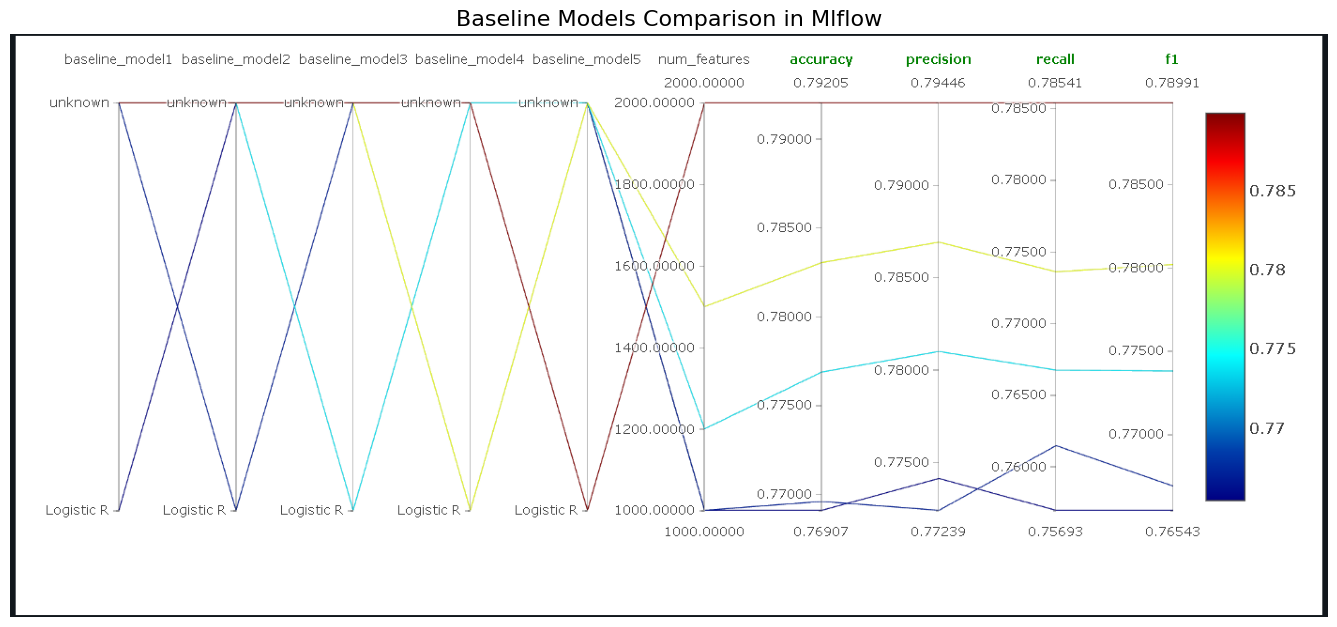

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("images/base_models_comparison.png")
plt.figure(figsize=(17, 13))
plt.imshow(img)
plt.title("Baseline Models Comparison in Mlflow", fontsize=16, color='black')
plt.axis('off')
plt.show()

##### Therefore, model evaluations metrics increases with increase in the size of vacabulary created using the Bag of Words technique.